# Train occupation classifiers and gender classifier using word embeddings


## Load bios

In [3]:
%pylab inline
from collections import Counter
import http.client, urllib.parse, json, time, sys
from glob import glob
from bs4 import BeautifulSoup as Soup
sys.path.append("../words")
import we
from sklearn.svm import LinearSVC, SVC
import numpy as np
import re, sys
import random
import scipy
from adjustText import adjust_text

import statsmodels.stats.proportion
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import sklearn.feature_selection 
from nltk.stem.porter import *
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import os, json
import re
import textblob
import langdetect
import pickle as pkl
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from bs4 import BeautifulSoup
from random import randint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import we
import os

import numpy as np
# from mag.experiment import Experiment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [4]:
bios = pkl.load(open('biosbias/data/BIOS_inferred.pkl','rb'))
data = bios
print(f'Data: {len(data)}')

# stratified split
labels_all = [bio['title'] for bio in data]
bios_data_train_val, bios_data_test = train_test_split(data, test_size=0.20, random_state=42, stratify=labels_all)

labels_train_val = [bio['title'] for bio in bios_data_train_val]
bios_data_train, bios_data_val = train_test_split(bios_data_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

# return bios_data_train, bios_data_val, bios_data_test


Data: 397907


In [5]:
sorted_occs = ['accountant', 'architect', 'attorney', 'chiropractor', 'comedian', 'composer',
 'dentist', 'dietitian', 'dj', 'filmmaker', 'interior_designer', 'journalist',
 'model', 'nurse', 'painter', 'paralegal', 'pastor', 'personal_trainer',
 'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper',
 'software_engineer', 'surgeon', 'teacher', 'yoga_teacher']

In [6]:
_f = Counter([p["title"] for p in bios_data_train if p["gender"]=="F"])
_m = Counter([p["title"] for p in bios_data_train if p["gender"]=="M"])
_t = Counter([p["title"] for p in bios_data_train])
fem = {t:_f[t]/float(_t[t]) for t in sorted_occs}

titles = sorted_occs.copy()
titles.sort(key=lambda t: fem[t])

In [7]:

#If we are using Common Crawl data, extract names
Counter([p["title"] for p in bios_data_train]).most_common()

[('professor', 71092),
 ('physician', 24661),
 ('attorney', 19627),
 ('photographer', 14629),
 ('journalist', 12004),
 ('nurse', 11401),
 ('psychologist', 11086),
 ('teacher', 9763),
 ('dentist', 8887),
 ('surgeon', 8196),
 ('architect', 6094),
 ('painter', 4656),
 ('model', 4523),
 ('poet', 4221),
 ('filmmaker', 4216),
 ('software_engineer', 4159),
 ('accountant', 3398),
 ('composer', 3373),
 ('dietitian', 2391),
 ('comedian', 1690),
 ('chiropractor', 1607),
 ('pastor', 1521),
 ('paralegal', 1063),
 ('yoga_teacher', 1001),
 ('dj', 894),
 ('interior_designer', 881),
 ('personal_trainer', 863),
 ('rapper', 846)]

In [8]:

vectorizer = CountVectorizer(binary = True, decode_error = u'ignore')
tokenizer = vectorizer.build_tokenizer()
def anonymize(p, remove_names=True, remove_gender_markers=True, remove_title=True, replacement="_"):
    bio = p["bio"]
    names = None
    if remove_title:
        i = bio.lower().index(p["norm_title"].lower())
        bio = p["bio"][:i] + replacement + p["bio"][i+len(p["norm_title"]):]

    if remove_gender_markers:
        bio = re.sub(r"\b(?:[Hh]e|[Ss]he|[Hh]er|[Hh]is|[Hh]im|[Hh]ers|[Hh]imself|[Hh]erself|[Mm][Rr]|[Mm][Rr][sS]|[Mm][Ss])\b", replacement, bio)
        
    if remove_names:
        prefix = bio[:bio.index(" is a")]
        names = {t for t in tokenizer(prefix) if t not in {'Dr', 'Mr', 'Ms', 'Mrs', 'Ph'}}
    #     print(names)
        if names:
            bio = re.sub(r"\b(?:" + "|".join([re.escape(n) for n in names]) + r")\b", replacement, bio)
    
    
    p["bio_"]=bio
    return names

In [10]:
with open("../../words/embeddings/OtherFormats/crawl-300d-2M.pkl", "rb") as f:
    E = pkl.load(f)
print("Loaded", len(E), "words")
 
def sim(w1, w2):
    return E[w1].dot(E[w2])/linalg.norm(E[w1])/linalg.norm(E[w2])
 
sim('he', 'she')

# token_counts = Counter([w for p in people for w in re.split(r"[\s\.\!\?\:,\"“\—\-\(\)]+", p["bio"]) if len(w)>1 and w in E.index])
# print(token_counts.most_common(100))

def word_vector_featurize(text, Emb = E):
    return mean([Emb[w] for w in re.split(r"[\s\.\!\?\:,\"“\—\-\(\)]+", text) if len(w)>1 and w in Emb], axis=0)

X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train]
X_val = [word_vector_featurize(p["bio"], E) for p in bios_data_val]
X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test]

print("Done featurizing")

Loaded 1999995 words
Done featurizing


In [123]:
def sim_emb(e1, e2):
    return e1.dot(e2)/linalg.norm(e1)/linalg.norm(e2)
 

In [24]:

def word_vector_featurize(text, Emb = E):
    return mean([Emb[w] for w in re.split(r"[\s\.\!\?\:,\"“\—\-\(\)]+", text) if len(w)>1 and w in Emb], axis=0)

X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train]
X_val = [word_vector_featurize(p["bio"], E) for p in bios_data_val]
X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test]

print("Done featurizing")

G_train = [p["gender"] for p in bios_data_train]
G_val = [p["gender"] for p in bios_data_val]
G_test = [p["gender"] for p in bios_data_test]

Done featurizing


In [11]:
# get data of female bios only (to train decoupled classifiers)
f_bios_train = [p for p in bios_data_train if p['gender']=='F']
f_bios_val = [p for p in bios_data_val if p['gender']=='F']
f_bios_test = [p for p in bios_data_test if p['gender']=='F']


f_X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train if p['gender']=='F']
f_X_val = [word_vector_featurize(p["bio"], E) for p in bios_data_val if p['gender']=='F']
f_X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test if p['gender']=='F']


f_G_train = [p["gender"] for p in f_bios_train]
f_G_val = [p["gender"] for p in f_bios_val]
f_G_test = [p["gender"] for p in f_bios_test]

In [54]:
#function to train classifier
def pred_clf(X, Y, G, X_pred=None, X_pred2=None, data_augm = False, subsample = False, random_state=42,balanced=False,sweights=None):
    if sweights is not None:
        clf = sklearn.linear_model.SGDClassifier(loss='log')
    
    else:
        if balanced:
            clf = sklearn.linear_model.SGDClassifier(loss='log',class_weight='balanced', random_state=42)
        else:
            clf = linear_model.LogisticRegression(penalty = 'l2', random_state=42,) 
    np.random.seed(random_state)
    random.seed(random_state)
    
    X_train, X_val, X_test = X
    Y_train, Y_val, Y_test = Y
    G_train, G_val, G_test = G
    
    Y, G = asarray(Y), asarray(G)
    
    if X_pred is None:
        X_pred = X_test
    
    #cross validation partitions for training and testing
    results = {'y_pred':[], 'y_pred_prob':[], 'y_pred_correct':[] , 'y_pred2':[], 'y_pred2_prob':[], 'y_pred2_correct':[],'y_pred_diff':[] }
    
    if data_augm:
        X_train = hstack((X_train, invert_gender(X_train, vectorizer)))
        Y_train = hstack((Y_train,Y_train))
    print("clf fit")
    if sweights is not None:
        clf.fit(X_train, Y_train, sample_weight=sweights)

    else:
        clf.fit(X_train, Y_train)
   
    y_pred = clf.predict(X_test)
    y_pred_proba =clf.predict_proba(X_test)
        
    results['y_pred'] = y_pred
    results['y_pred_prob'] = y_pred_proba
    results['y_pred_correct'] = y_pred== array(Y_test)
        
    if X_pred2 is not None:
        y_pred2 = clf.predict(X_pred2)
        y_pred2_proba =clf.predict_proba(X_pred2)
        results['y_pred2'] = y_pred2
        results['y_pred2_prob'] = y_pred2_proba
        results['y_pred2_correct'] = y_pred2== array(Y_test)
        results['y_pred_diff'] = y_pred2_proba-y_pred_proba
        
    return results, clf

# Occupation classifiers (joint and decoupled)

In [30]:
# Train joint Occupation classifiers

occ_classers = {}

occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    Y_train = [p["title"]==target_occ for p in bios_data_train]

    Y_val = [p["title"]==target_occ for p in bios_data_val]

    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    f_Y_train = [p["title"]==target_occ for p in f_bios_train]
    f_Y_val = [p["title"]==target_occ for p in f_bios_val]
    f_Y_test = [p["title"]==target_occ for p in f_bios_test]
    
    
    pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],balanced=True)
    
    pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)
    
    
    occ_classers[target_occ] = {}
    occ_classers[target_occ]['clf_bow_joint'] = clf_bow_joint
    occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
    occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
    occ_classers[target_occ]['pred_bow_f'] = pred_bow_f

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [99]:
# Train male Occupation classifiers

m_bios_train = [p for p in bios_data_train if p['gender']=='M']
m_bios_val = [p for p in bios_data_val if p['gender']=='M']
m_bios_test = [p for p in bios_data_test if p['gender']=='M']



m_X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train if p['gender']=='M']
m_X_val = [word_vector_featurize(p["bio"], E) for p in bios_data_val if p['gender']=='M']
m_X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test if p['gender']=='M']

m_G_train = [p["gender"] for p in m_bios_train]
m_G_val = [p["gender"] for p in m_bios_val]
m_G_test = [p["gender"] for p in m_bios_test]

occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    m_Y_train = [p["title"]==target_occ for p in m_bios_train]
    m_Y_val = [p["title"]==target_occ for p in m_bios_val]
    m_Y_test = [p["title"]==target_occ for p in m_bios_test]
    
    pred_bow_m, clm_bow_m = pred_clf([m_X_train, m_X_val, m_X_test], [m_Y_train, m_Y_val, m_Y_test], [m_G_train,m_G_val,m_G_test],balanced=True)
    occ_classers[target_occ]['clm_bow_m'] = clm_bow_m
    occ_classers[target_occ]['pred_bow_m'] = pred_bow_m

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [31]:
# Train female Occupation classifiers

target_occ = 'all'
Y_train = [p["title"] for p in bios_data_train]

Y_val = [p["title"] for p in bios_data_val]

Y_test = [p["title"] for p in bios_data_test]

f_Y_train = [p["title"] for p in f_bios_train]
f_Y_val = [p["title"] for p in f_bios_val]
f_Y_test = [p["title"] for p in f_bios_test]


pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],balanced=True)

pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)


occ_classers[target_occ] = {}
occ_classers[target_occ]['clf_bow_joint'] = clf_bow_joint
occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
occ_classers[target_occ]['pred_bow_f'] = pred_bow_f

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [330]:
# Save Occupation classifiers

pkl.dump(occ_classers,open('results/we_occ_classers.pkl','wb'))

# Gender classifiers

In [47]:
# unbalanced gender classifier
unbalanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
unbalanced_gender_clf.fit(X_train, G_train)
pkl.dump(unbalanced_gender_clf,open('results/we_unbal_g.pkl','wb'))


In [283]:
# balanced gender classifier, so occupation is not used as a proxy for gender

occs_full = np.unique([p['title'] for p in bios_data_train])

#make sample weights:
sample_weights=[]

# populate dictionary of weights to be inverse to the gender ratios within each occupation
valdict = {}
for t in occs_full:
        fval = _m[t] / max(_f[t],_m[t])
        mval = _f[t] / max(_f[t],_m[t])
        valdict[t] = {}
        valdict[t]['F'] = fval
        valdict[t]['M'] = mval
    
sample_weights = [valdict[p['title']][p['gender']] for p in bios_data_train]

balanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
balanced_gender_clf.fit(X_train, G_train,sample_weight=sample_weights)
pkl.dump(balanced_gender_clf,open('results/we_bal_g.pkl','wb'))

In [127]:
balanced_gender_clf=pkl.load(open('results/we_bal_g.pkl','rb'))

In [190]:
print(sklearn.metrics.classification_report(G_test,balanced_gender_clf.predict(X_test)))

              precision    recall  f1-score   support

           F       0.66      0.64      0.65     36538
           M       0.70      0.72      0.71     43044

    accuracy                           0.68     79582
   macro avg       0.68      0.68      0.68     79582
weighted avg       0.68      0.68      0.68     79582



In [49]:
# single occupation gender classifiers (trained only on people within a particular classifier)
single_gender_classers = {}
occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]

for occ in occs:
#     print(occ)
    cand_X = [i for i,p in enumerate(bios_data_train) if p['title']==occ]
#     irrev_X_train = decorr_with_occ(np.array(X_train)[cand_X], occ)
    

    balanced_gender_clf = sklearn.linear_model.SGDClassifier(loss='log')
    balanced_gender_clf.fit(np.array(X_train)[cand_X],np.array(G_train)[cand_X])
    
    single_gender_classers[occ] = balanced_gender_clf

In [ ]:
pkl.dump(single_gender_classers,open('results/we_single_gender_classers.pkl','wb'))

# Analyze SNoB

In [250]:
# get correlations r_c for joint, decoupled, and balancing TPR
f_frac = np.load('results/f_frac.npy')
y_preds_tpr = pkl.load(open('results/we_tpr_fairlearn_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
tpr_corr_full = []
for target_occ in occs:
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    cand_women_X_full =  [word_vector_featurize(p["bio"], E) for p in cand_women]
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)

    occ_probs =  y_preds_tpr[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]

    tpr_corr_full.append(corr)

In [232]:

print(np.cov(f_frac,joint_corr_full[:25])[0,1])
print(np.cov(f_frac,decoupled_corr_full[:25])[0,1])
print(np.cov(f_frac,tpr_corr_full[:25])[0,1])

0.04575204522089011
0.04026738892180747
0.022257668076644165


[]

In [406]:

print(np.cov(f_frac,joint_corr_full[:25])[0,1])
print(np.cov(f_frac,decoupled_corr_full[:25])[0,1])
print(np.cov(f_frac,tpr_corr_full[:25])[0,1])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 25 and the array at index 1 has size 0

In [233]:
# with gender_irrev classifier
print(np.cov(f_frac,joint_corr[:25])[0,1])
print(np.cov(f_frac,decoupled_corr[:25])[0,1])
print(np.cov(f_frac,tpr_corr[:25])[0,1])

0.010032500140995593
0.015166832506346126
0.0017709195951907506


Text(0.5, 1.0, 'LR-WE (M only)')

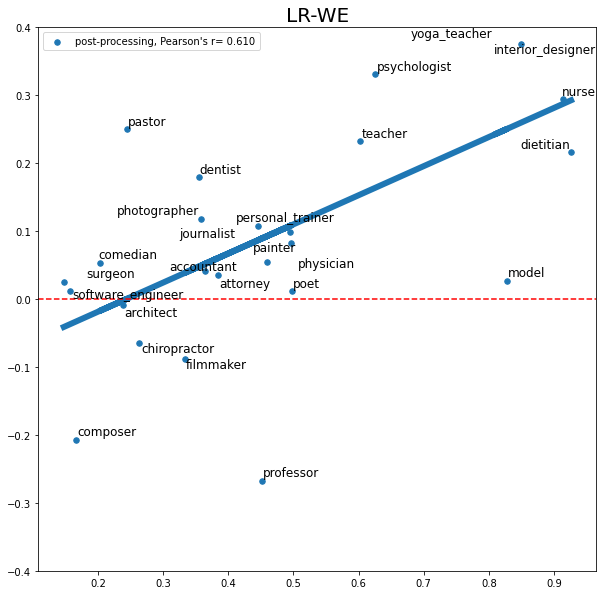

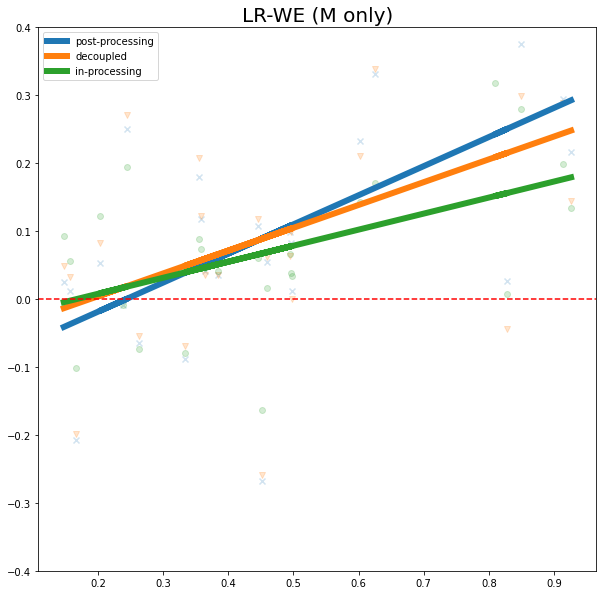

In [68]:
# plot for men only (old plot, not used)
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/we_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
eo_corr_full = []
for target_occ in occs:
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='M']
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='M'])
    cand_women_X_full =  [word_vector_featurize(p["bio"], E) for p in cand_women]
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)

    occ_probs =  y_preds_eo[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    eo_corr_full.append(corr)
pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,s=30,label='post-processing, Pearson\'s r= %.3f'%(scipy.stats.pearsonr( f_frac,joint_corr_full)[0]))
plt.plot(xs, m*xs+ b,linewidth=6)

plt.legend()

plt.axhline(y=0, color='r', linestyle='dashed')


x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
texts = [plt.text(x,y,l,size=12) for x, y, l in zip(f_frac, joint_corr_full, occs)]
adjust_text(texts)
# xlabel(x_label,size = 20 )
# ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("LR-WE",fontsize=20)

plt.figure()

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr_full,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr_full,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr_full, occs)]
adjust_text(texts)
# xlabel(x_label,size = 20 )
# ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("LR-WE (M only)",fontsize=20)
    

    
    

In [332]:
words = np.load('results/words.npy')
def sort_helper(i):
    x = words[i]
    if x in words_by_freq:
        return words_by_freq[x]
    return 0

# plot for 25-way classifier (instead of one vs. all)

Text(0.5, 1.0, 'LR-WE (F only), 25-way classifier')

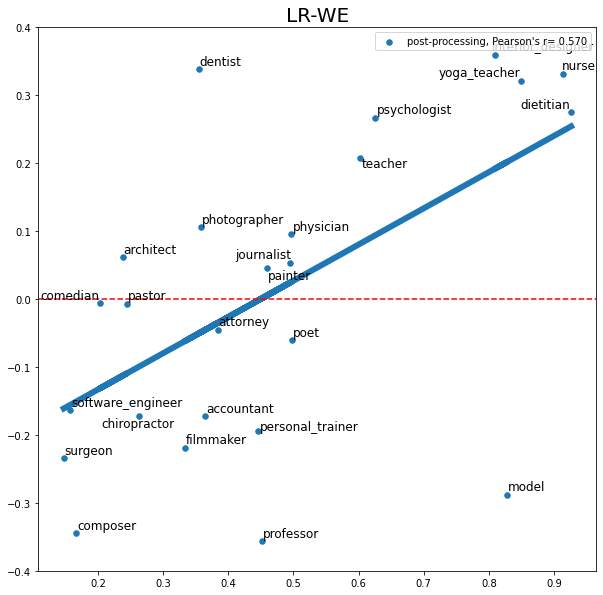

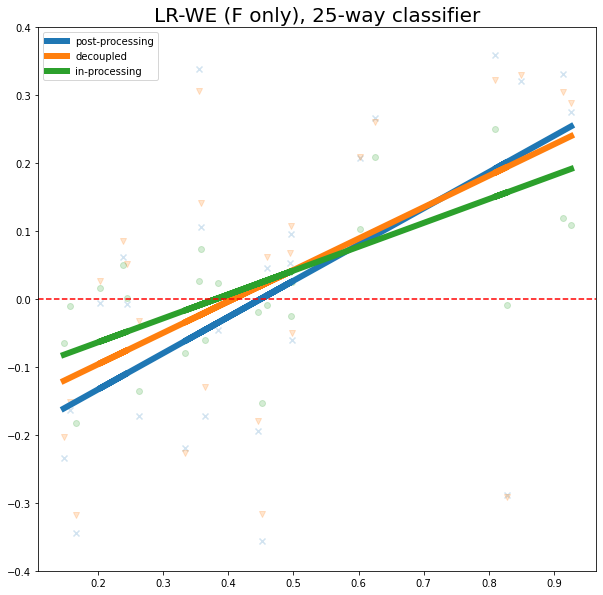

In [181]:
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/we_eo_y_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
eo_corr_full = []
for target_occ in occs:
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    cand_women_X_full =  [word_vector_featurize(p["bio"], E) for p in cand_women]
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    
    occ_ind = np.where(occ_classers['all']['clf_bow_joint'].classes_ == target_occ)[0][0]
    occ_probs = occ_classers['all']['clf_bow_joint'].predict_proba(cand_women_X_full)[:,occ_ind]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers['all']['clf_bow_f'].predict_proba(cand_women_X_full)[:,occ_ind]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)

    occ_probs =  y_preds_eo[target_occ][cand_women_inds][:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    eo_corr_full.append(corr)
    
    
#     occ_probs =  y_preds_dp[target_occ][cand_women_inds][:,1]
#     corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
#     dp_corr_full.append(corr)

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,s=30,label='post-processing, Pearson\'s r= %.3f'%(scipy.stats.pearsonr( f_frac,joint_corr_full)[0]))
plt.plot(xs, m*xs+ b,linewidth=6)

plt.legend()

plt.axhline(y=0, color='r', linestyle='dashed')


x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
texts = [plt.text(x,y,l,size=12) for x, y, l in zip(f_frac, joint_corr_full, occs)]
adjust_text(texts)
# xlabel(x_label,size = 20 )
# ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("LR-WE",fontsize=20)

plt.figure()

pylab.rcParams['figure.figsize'] = (10, 10)
xs = np.array(f_frac).reshape(-1,)

m, b = np.polyfit(xs, np.array(joint_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,joint_corr_full,marker='x',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='post-processing')

m, b = np.polyfit(xs, np.array(decoupled_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,decoupled_corr_full,marker='v',alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='decoupled')


m, b = np.polyfit(xs, np.array(eo_corr_full).reshape(-1,), 1)
plt.scatter(f_frac,eo_corr_full,alpha=0.2)
plt.plot(xs, m*xs+ b,linewidth=6,label='in-processing')
plt.legend()


plt.axhline(y=0, color='r', linestyle='dashed')

x_label = "% FEMALE"
y_label = 'Correlation between Occupation and Gender Probs'
# texts = [plt.text(x,y,l) for x, y, l in zip(f_frac, decoupled_corr_full, occs)]
adjust_text(texts)
# xlabel(x_label,size = 20 )
# ylabel(y_label, size=20)
plt.ylim([-0.4, 0.4])
plt.title("LR-WE (F only), 25-way classifier",fontsize=20)
    

    
    

# Examine Nonbinary bios

In [381]:
nb_bios = pd.read_pickle('results/nb_prof.pkl')
nb_bios_list = list(nb_bios['bio'])

In [346]:
nb_bios_list = list(nb_bios['bio'])

In [405]:
nb_bios_list

['They received their doctorate in Public Affairs at the University of Colorado Denver in 2014. Their research interests and focus are on issues of LGBTQ equality and equity in both criminal and social justice. They have published work on hate crime laws and gender in policing. They regularly teach courses on Criminology, Policing, Sex Crimes, Research Methods, and Hate Crimes.',
 'They received their PhD from Princeton University after completing their MA at the University of Notre Dame. _’s research focuses on feminist philosophy and metaphysics, with a particular emphasis on the social construction of gender and sexual orientation.',
 'They received their PhD from Princeton University. _’s research focuses on metaethics and philosophy of law, with a particular emphasis on moral and social norms.',
 'They have previously worked at San Francisco State University, Carlos III University of Madrid, and Autonomous University of Barcelona. Two extreme emotions brought Ayala to philosophy: 

In [403]:
f_frac = np.load('results/f_frac.npy')
balanced_gender_clf=pkl.load(open('results/we_bal_g.pkl','rb'))

joint_corr_full = []
decoupled_corr_full = []
# eo_corr_full = []
# for target_occ in occs:
target_occ='professor'
cand_women_X_full =  [word_vector_featurize(p, E) for p in nb_bios_list]
gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]

occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("joint")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("pre-processing")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled F")
print(corr)


cc_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled M")
print(corr)

joint
0.29480519480519485
pre-processing
0.2922077922077922
decoupled F
0.31428571428571433
decoupled M
0.31428571428571433


In [411]:
f_frac = np.load('results/f_frac.npy')
balanced_gender_clf=pkl.load(open('results/we_bal_g.pkl','rb'))

joint_corr_full = []
decoupled_corr_full = []
# eo_corr_full = []
# for target_occ in occs:
target_occ='professor'
cand_women_X_full =  [word_vector_featurize(p['bio'], E) for p in bios_data_test if p['title']=='professor' and p['gender']=='F']
gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]

occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("joint")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("pre-processing")
print(corr)

occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled F")
print(corr)


cc_probs = occ_classers[target_occ]['clm_bow_m'].predict_proba(cand_women_X_full)[:,1]
corr = spearmanr(occ_probs,gender_probs)
print("decoupled M")
print(corr)

joint
SpearmanrResult(correlation=-0.023385682751791557, pvalue=0.015671384362347846)
pre-processing
SpearmanrResult(correlation=-0.012079890959109385, pvalue=0.2119910220176095)
decoupled F
SpearmanrResult(correlation=-0.01306103208990543, pvalue=0.17717951059765227)
decoupled M
SpearmanrResult(correlation=-0.01306103208990543, pvalue=0.17717951059765227)


# get accuracies

In [350]:
#takes as input a dictionary that is outputed by cv_pred()
def pred_summary(pred_dic, Y_test, G_test):
    #wildcard aggregates over different classes/genders
    wildcard = "*"
    genders = sorted(set(G_test)) + [wildcard]
    ys = sorted(set(Y_test)) + [wildcard]
    summary =  {y: {g: [] for g in genders} for y in ys} 
    for y in ys:
        for gender in genders:
            #print(y,sum(array(Y_test)==y))
            #accuracies = []
            bool_subgroup = [y_pred==y_true for y_pred, y_true, g in zip(pred_dic, Y_test, G_test) 
                        if (gender==wildcard or gender==g) and (y==wildcard or y==y_true)]
            acc=mean(bool_subgroup)
            summary[y][gender]=acc    
    return summary

def get_rms_gap(pred_summaries):
    temp_occ=np.array(pred_summaries)
    orig_gap = []
    for p in temp_occ:
        orig_gap.append(p[True]['F']-p[True]['M'])
    orig_gap=np.array(orig_gap)
    return np.sqrt(np.sum(orig_gap**2)/25)

In [198]:
y_preds_tpr = pkl.load(open('results/we_tpr_fairlearn_preds.pkl','rb'))
originals_occ = []
tprs_occ = []
decoupled_occ=[]
#equalized odds
# cand_women_X =  [word_vector_featurize(p['bio'], E) for p in bios_data_test]
X_test = np.array(X_test)
for target_occ in occs:
    temp_inds = [i for i,p in enumerate(bios_data_test) if p['title']==target_occ ]
    Y_test = [p["title"]==target_occ for p in np.array(bios_data_test)[temp_inds]]
    y_pred_unmit = occ_classers[target_occ]['clf_bow_joint'].predict(X_test[temp_inds])
    f_inds = [p["gender"]=='F' for p in np.array(bios_data_test)[temp_inds]]
    
    y_preds_f = occ_classers[target_occ]['clf_bow_f'].predict(X_test[temp_inds])
    y_preds_m = occ_classers[target_occ]['clm_bow_m'].predict(X_test[temp_inds])
    y_preds_m[f_inds] = y_preds_f[f_inds]

    
    G_test = np.array(G_test)
    y_pred_tpr =  (np.argmax(y_preds_tpr[target_occ],axis=1)==1)[temp_inds]#[:,1]
    a=pred_summary(y_pred_unmit, Y_test, G_test[temp_inds])
    
    c=pred_summary(y_preds_m, Y_test, G_test[temp_inds])
    b=pred_summary(y_pred_tpr, Y_test, G_test[temp_inds])
    originals_occ.append(a)
    tprs_occ.append(b)
    decoupled_occ.append(c)

In [353]:
temp_occ = []
X_test = np.array(X_test)
for target_occ in occs:
    temp_inds = [i for i,p in enumerate(bios_data_test) if p['title']==target_occ ]
    Y_test = [p["title"]==target_occ for p in np.array(bios_data_test)[temp_inds]]
    y_pred_pr = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict(X_test[temp_inds])
    a=pred_summary(y_pred_pr, Y_test, G_test[temp_inds])
    
    temp_occ.append(a)
temp_occ=np.array(temp_occ)

In [358]:
temp_gap = []
for p in temp_occ:
    temp_gap.append(p[True]['F']-p[True]['M'])
temp_gap=np.array(temp_gap)
np.sqrt(np.sum(temp_gap**2)/25)

0.06127229455139132

In [199]:
originals_occ=np.array(originals_occ)
tprs_occ=np.array(tprs_occ)
decoupled_occ=np.array(decoupled_occ)

In [201]:
orig_gap = []
for p in originals_occ:
    orig_gap.append(p[True]['F']-p[True]['M'])
orig_gap=np.array(orig_gap)
dec_gap = []
for p in decoupled_occ:
    dec_gap.append(p[True]['F']-p[True]['M'])
dec_gap=np.array(dec_gap)
tpr_gap = []
for p in tprs_occ:
    tpr_gap.append(p[True]['F']-p[True]['M'])
tpr_gap=np.array(tpr_gap)


In [207]:
np.sqrt(np.sum(orig_gap**2)/25)

0.060639234482362664

In [208]:
np.sqrt(np.sum(tpr_gap**2)/25)

0.05982944280333841

In [260]:
# WE original accuracy
accs=[]
for target_occ in occs:
    
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clf_bow_joint'].predict(X_test)))
np.mean(accs)

0.9377849262396021

In [359]:
# WE PR accuracy
accs=[]
for target_occ in occs:
    
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict(X_test)))
np.mean(accs)

0.9419506923676209

In [310]:
#25 way accuracy
Y_test = [p["title"] for p in bios_data_test]
    
sklearn.metrics.accuracy_score(Y_test,occ_classers['all']['clf_bow_joint'].predict(X_test))

0.7371516171998693

In [265]:
# decoupled accuracy (F)
accs=[]
for target_occ in occs:
    
    Y_test = [p["title"]==target_occ for p in bios_data_test if p['gender']=='F']
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clf_bow_f'].predict(f_X_test)))

In [266]:
np.mean(accs)

0.943463791121572

In [267]:
# decoupled accuracy (M)
accs=[]
for target_occ in occs:
    
    Y_test = [p["title"]==target_occ for p in bios_data_test if p['gender']=='M']
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,occ_classers[target_occ]['clm_bow_m'].predict(m_X_test)))

In [268]:
np.mean(accs)

0.9299256574667781

In [270]:
(0.943463791121572+0.9299)/2

0.936681895560786

In [272]:
# WE RE accuracy

accs=[]

y_preds_tpr = pkl.load(open('results/we_tpr_fairlearn_preds.pkl','rb'))
for target_occ in occs:
    
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,np.argmax(y_preds_tpr[target_occ],axis=1)==1))
print(np.mean(accs))

0.8791621220879093


In [281]:
# WE PO accuracy
from fairlearn.postprocessing import ThresholdOptimizer
pps={}
for target_occ in occs:
    new_opter = ThresholdOptimizer(estimator=occ_classers[target_occ]['clf_bow_joint'], constraints='true_positive_rate_parity')
    Y_train = [p["title"]==target_occ for p in bios_data_train]
    new_opter.fit(X_train,Y_train,sensitive_features=G_train)
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    preds = new_opter.predict(X_test,sensitive_features=G_test)
    pps[target_occ] = (new_opter, preds)
    

# Cross val

In [55]:
bios = pkl.load(open('biosbias/data/BIOS_inferred.pkl','rb'))
data = np.array(bios)
print(f'Data: {len(data)}')

# stratified split
labels_all = [bio['title'] for bio in data]
# train_test_split(data, test_size=0.20, random_state=42, stratify=labels_all)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(bios, labels_all)
print(skf)
# StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
fold_ind = 0

occ_classers_cv = {}
for train_index, test_index in skf.split(data, labels_all):
    print(fold_ind)
    occ_classers_cv[fold_ind] = {}
    occ_classers_cv[fold_ind]['inds'] = test_index
    bios_data_train, bios_data_test = data[train_index], data[test_index]
    
    
    # Train Occupation classifiers


    X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train]
    X_val = X_test
    X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test]
    G_train = [p["gender"] for p in bios_data_train]
    G_test = [p["gender"] for p in bios_data_test]

    G_val = G_test


    occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
    for target_occ in occs:
        Y_train = [p["title"]==target_occ for p in bios_data_train]

        Y_val = [p["title"]==target_occ for p in bios_data_test]

        Y_test = [p["title"]==target_occ for p in bios_data_test]

#         f_Y_train = [p["title"]==target_occ for p in f_bios_train]
#         f_Y_val = [p["title"]==target_occ for p in f_bios_test]
#         f_Y_test = [p["title"]==target_occ for p in f_bios_test]


        pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],balanced=True)

#         pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)


        occ_classers_cv[fold_ind][target_occ] = {}
        occ_classers_cv[fold_ind][target_occ]['clf_bow_joint']= clf_bow_joint
        occ_classers_cv[fold_ind][target_occ]['pred_bow_joint'] = pred_bow_joint
#         occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
#         occ_classers[target_occ]['pred_bow_f'] = pred_bow_f
    fold_ind += 1


Data: 397907
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
0


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit
1


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit
3


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit
4


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [56]:
pkl.dump(occ_classers_cv,open('results/we_occ_classers_crossval.pkl','wb'))

In [57]:
totals_s = pkl.load(open('totals_single.pkl','rb'))

In [58]:
totals_s.keys()

dict_keys(['surgeon', 'software_engineer', 'composer', 'pastor', 'comedian'])

In [60]:
totals_s['surgeon']

(KFold(n_splits=5, random_state=17, shuffle=True),
 [(array([0.08454197]),
   array([0., 0., 0., ..., 0., 0., 0.]),
   SGDClassifier(class_weight='balanced', loss='log', random_state=42)),
  (array([0.06986721]),
   array([0., 0., 0., ..., 0., 0., 1.]),
   SGDClassifier(class_weight='balanced', loss='log', random_state=42)),
  (array([0.08074913]),
   array([1., 0., 0., ..., 0., 0., 0.]),
   SGDClassifier(class_weight='balanced', loss='log', random_state=42)),
  (array([0.07187756]),
   array([0., 0., 0., ..., 0., 0., 0.]),
   SGDClassifier(class_weight='balanced', loss='log', random_state=42)),
  (array([0.07056094]),
   array([0., 0., 0., ..., 0., 0., 1.]),
   SGDClassifier(class_weight='balanced', loss='log', random_state=42))])

In [69]:
bios = pkl.load(open('biosbias/data/BIOS_inferred.pkl','rb'))
# def load_data(filename):
data = bios
print(f'Data: {len(data)}')

# stratified split
labels_all = [bio['title'] for bio in data]
bios_data_train_val, bios_data_test = train_test_split(data, test_size=0.20, random_state=42, stratify=labels_all)

labels_train_val = [bio['title'] for bio in bios_data_train_val]
bios_data_train, bios_data_val = train_test_split(bios_data_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)



X_train = [word_vector_featurize(p["bio"], E) for p in bios_data_train]
X_val = [word_vector_featurize(p["bio"], E) for p in bios_data_val]
X_test = [word_vector_featurize(p["bio"], E) for p in bios_data_test]

G_train = [p["gender"] for p in bios_data_train]
G_val = [p["gender"] for p in bios_data_val]
G_test = [p["gender"] for p in bios_data_test]

bios_all = np.concatenate([bios_data_train,bios_data_test])
G_all = np.concatenate([G_train,G_test])
X_all = np.concatenate([X_train,X_test])
X_all.shape

Y_all = [p["title"]==target_occ for p in bios_all]
stacked_all = np.hstack([X_all,np.array([int(g == 'F') for g in G_all]).reshape(-1,1),np.array([int(g) for g in Y_all]).reshape(-1,1)])


# ans = my_kfold(stacked_all, transfer_eval, n_folds=5,called_from_start=True)

Data: 397907


In [82]:
target_occ='surgeon'
kf = totals_s[target_occ][0]


Y_all = [p["title"]==target_occ for p in bios_all]
stacked_all = np.hstack([X_all,np.array([int(g == 'F') for g in G_all]).reshape(-1,1),np.array([int(g) for g in Y_all]).reshape(-1,1)])

# preds = np.zeros((29441+29370+29474+29272+29308)) #num women
count = 0
preds = []
for (train_idx), test_idx in kf.split(stacked_all):
#     print(len(test_idx))
#     actual_inds = 
#     print(len(totals_s[target_occ][1][count][1]))
    X_te = stacked_all[test_idx]
    indexes_test = np.where(X_te[:, -2]==1)
    preds.append(X_te[indexes_test])
    count+=1
    
a=np.concatenate(preds, axis=0)[:,-1] #Y_true

#     print(test_idx[:5])

# Train classifiers with pre-processing and get values for table

In [287]:
# balanced

occs_full = np.unique([p['title'] for p in bios_data_train])
#make sample weights
# sample_weights=[]
valdict = {}
for t in occs_full:
        fval = _m[t] / max(_f[t],_m[t])
        mval = _f[t] / max(_f[t],_m[t])
        valdict[t] = {}
        valdict[t]['F'] = fval
        valdict[t]['M'] = mval
    
# for :
sample_weights = np.array([valdict[p['title']][p['gender']] for p in bios_data_train])

#  n_samples / (n_classes * np.bincount(​y)



In [302]:
classweights = len(Y_train)/np.bincount(Y_train)
    
class_weights_arr = np.array([classweights[int(k)] for k in Y_train])
bal_sample_weights = sample_weights * class_weights_arr

In [304]:
# Train Occupation classifiers


occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
for target_occ in occs:
    Y_train = [p["title"]==target_occ for p in bios_data_train]

    Y_val = [p["title"]==target_occ for p in bios_data_val]

    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    classweights = len(Y_train)/np.bincount(Y_train)
    
    
    class_weights_arr = np.array([classweights[int(k)] for k in Y_train])
    bal_sample_weights = sample_weights * class_weights_arr
    pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],sweights=bal_sample_weights)
    
#     pred_bow_f, clf_bow_f = pred_clf([f_X_train, f_X_val, f_X_test], [f_Y_train, f_Y_val, f_Y_test], [f_G_train,f_G_val,f_G_test],balanced=True)
    
    
#     occ_classers[target_occ] = {}
    occ_classers[target_occ]['clf_bow_joint_sampleweights'] = clf_bow_joint
    occ_classers[target_occ]['pred_bow_joint'] = pred_bow_joint
#     occ_classers[target_occ]['clf_bow_f'] = clf_bow_f
#     occ_classers[target_occ]['pred_bow_f'] = pred_bow_f

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [305]:
#train 25-way
Y_train = [p["title"] for p in bios_data_train]

Y_val = [p["title"] for p in bios_data_val]

Y_test = [p["title"] for p in bios_data_test]
pred_bow_joint, clf_bow_joint = pred_clf([X_train, X_val, X_test], [Y_train, Y_val, Y_test], [G_train,G_val,G_test],sweights=sample_weights)
occ_classers['all']['clf_bow_joint_sampleweights'] = clf_bow_joint

/home/adam/Dropbox/WorkProjects/venv_main/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


clf fit


In [306]:
f_frac = np.load('results/f_frac.npy')
y_preds_eo = pkl.load(open('results/we_eo_y_preds.pkl','rb'))
joint_corr_sample = []
# decoupled_corr_full = []
# eo_corr_full = []
for target_occ in occs:
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    cand_women_X_full =  [word_vector_featurize(p["bio"], E) for p in cand_women]
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    
    occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    corr = scipy.stats.pearsonr(occ_probs,gender_probs)[0]
    joint_corr_sample.append(corr)

In [363]:
print(np.cov(f_frac,joint_corr_sample[:25])[0,1])

0.038429855218008985


In [308]:

accs = []
for target_occ in occs:
    Y_test = [p["title"]==target_occ for p in bios_data_test]
    
    accs.append(sklearn.metrics.accuracy_score(Y_test,pps[target_occ][1]))
print(np.mean(accs))

0.9714307255409516


In [365]:
pkl.dump((joint_corr_full,decoupled_corr_full,tpr_corr_full,joint_corr_sample),open('results/corrs_we.pkl','wb'))

# Spearman correlation

In [397]:
from scipy.stats import spearmanr

In [399]:
# get correlations r_c for joint, decoupled, and balancing TPR
f_frac = np.load('results/f_frac.npy')
y_preds_tpr = pkl.load(open('results/we_tpr_fairlearn_preds.pkl','rb'))
joint_corr_full = []
decoupled_corr_full = []
tpr_corr_full = []
joint_corr_sample = []
for target_occ in occs:
    cand_women = [p for p in bios_data_test if p["title"]==target_occ and p['gender']=='F']
    cand_women_inds = np.array([i for i,p in enumerate(bios_data_test) if p["title"]==target_occ and p['gender']=='F'])
    cand_women_X_full =  [word_vector_featurize(p["bio"], E) for p in cand_women]
    gender_probs = balanced_gender_clf.predict_proba(cand_women_X_full)[:,0]
    
    occ_probs = occ_classers[target_occ]['clf_bow_joint'].predict_proba(cand_women_X_full)[:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]
    joint_corr_full.append(corr)
    
    occ_probs = occ_classers[target_occ]['clf_bow_f'].predict_proba(cand_women_X_full)[:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]
    decoupled_corr_full.append(corr)

    occ_probs =  y_preds_tpr[target_occ][cand_women_inds][:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]

    tpr_corr_full.append(corr)
    
    
    occ_probs = occ_classers[target_occ]['clf_bow_joint_sampleweights'].predict_proba(cand_women_X_full)[:,1]
    corr = spearmanr(occ_probs,gender_probs)[0]
    joint_corr_sample.append(corr)

In [401]:
print("PR, PO, DE, RE")
print(np.cov(f_frac,joint_corr_sample[:25])[0,1])
print(np.cov(f_frac,joint_corr_full[:25])[0,1])
print(np.cov(f_frac,decoupled_corr_full[:25])[0,1])
print(np.cov(f_frac,tpr_corr_full[:25])[0,1])


PR, PO, DE, RE
0.04574952845739755
0.05677285312865159
0.05050801684695415
0.010954827048626251


In [402]:
pkl.dump((joint_corr_full,decoupled_corr_full,tpr_corr_full,joint_corr_sample),open('results/corrs_we_spearman.pkl','wb'))

In [ ]:
words = np.array(vectorizer.get_feature_names())
# occs = ["surgeon", "software_engineer", "composer", "pastor", "comedian", "architect", "chiropractor", "accountant", "attorney", "filmmaker", "physician", "dentist", "photographer", "professor", "painter", "journalist", "poet", "personal_trainer", "teacher", "psychologist",  "model", "interior_designer", "yoga_teacher", "nurse", "dietitian"]
all_proxy_words = []
for target_occ in occs:
    print(target_occ)
    gender_dots = balanced_gender_clf.coef_[0]
    f_dots = occ_classers[target_occ]['clf_bow_f'].coef_[0]
    m_dots = occ_classers[target_occ]['clm_bow_m'].coef_[0]
    j_dots = occ_classers[target_occ]['clf_bow_joint'].coef_[0]
    
    small_thr = 0.7
    gender_thr = 0.45
    #feminine
    inds = np.where(((abs(j_dots) < small_thr*abs(f_dots)) & (abs(j_dots) < small_thr*abs(m_dots))) & ((gender_dots < -gender_thr) & (abs(f_dots)>gender_thr)))[0]
    print(words[inds])
    all_proxy_words.extend(words[inds])
    #masculine
    inds = np.where(((abs(j_dots) < small_thr*abs(f_dots)) & (abs(j_dots) < small_thr*abs(m_dots))) & ((gender_dots >gender_thr) & (abs(f_dots)>gender_thr)))[0]

    print(words[inds])
    all_proxy_words.extend(words[inds])
#     print(j_dots[indsextef_dots[inds])
print(set(all_proxy_words))